# Prepare the datasets and the pretrained model

In [ ]:
!pip install transformers sentencepiece datasets evaluate accelerate -U

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 80.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 79.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.2/486.2 kB 38.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.6/227.6 kB 27.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 20.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 76.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 41.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━

In [ ]:
import transformers as ts
import torch
import accelerate
import sentencepiece
import pandas as pd
from datasets import Dataset
import evaluate
import numpy as np
from sklearn.metrics import accuracy_score, balanced_accuracy_score, confusion_matrix, ConfusionMatrixDisplay

pd.options.display.max_columns = None
pd.options.display.max_colwidth = 400

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#prepares the dataframe and turns into dataset
def prepare_df(df):
  # add the ADE column
  df['ADE'] = 0
  # check if any ADE specific column has value 1, then ADE = 1
  for x in range(0, len(df)):
    sample = df.loc[x][df.columns[2:24]]
    if 1 in sample.values:
      df.at[x, 'ADE'] = 1
    #print(x)
  # keep the columns we need for binary classification
  df = df[['train_id', 'text', 'ADE']]
  df.rename(columns={'train_id' : 'id', 'ADE' : 'labels'}, inplace=True)
  #dataset = Dataset.from_pandas(df)
  #dataset = dataset.train_test_split(test_size=0.2, shuffle=False)
  return df

In [ ]:
#map label int value to a string
id2label = {0: "NEGATIVE", 1: "POSITIVE"}
label2id = {"NEGATIVE": 0, "POSITIVE": 1}

accuracy = evaluate.load("accuracy")

In [ ]:
SAVE_PATH_EN = "/content/drive/MyDrive/en_md_1/"
SAVE_PATH_FR = "/content/drive/MyDrive/fr_md_1/"
SAVE_PATH_DE = "/content/drive/MyDrive/de_md_1/"
SAVE_PATH_JA = "/content/drive/MyDrive/ja_md_1/"
#HYPERPARAMETRES
batch_size=32
epochs=5
lr=2e-5
wd=0.01

In [ ]:
#to compute accuracy at the end of each epoch
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

In [ ]:
training_args = ts.TrainingArguments(
    output_dir="./results",
    learning_rate=lr,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=epochs,
    evaluation_strategy="epoch",
    save_strategy="no",
    weight_decay=wd,
    optim="adamw_torch"
)

In [ ]:
model = ts.AutoModelForSequenceClassification.from_pretrained("cambridgeltl/SapBERT-UMLS-2020AB-all-lang-from-XLMR", num_labels=2, id2label=id2label, label2id=label2id)
tokenizer = ts.AutoTokenizer.from_pretrained("cambridgeltl/SapBERT-UMLS-2020AB-all-lang-from-XLMR")
data_collator = ts.DataCollatorWithPadding(tokenizer=tokenizer)
#tokenize the texts and truncate according to the tokenizer's max input length
def prep(examples):
    return tokenizer(examples["text"], truncation=True)

Some weights of the model checkpoint at cambridgeltl/SapBERT-UMLS-2020AB-all-lang-from-XLMR were not used when initializing XLMRobertaForSequenceClassification: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at cambridgeltl/SapBERT-UMLS-2020AB-all-lang-from-XLMR and are newly initialized: ['classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.weight', 'classifier.dense.bias

In [ ]:
#prepare the English dataset
df = pd.read_csv('/content/drive/MyDrive/ntcir17_mednlp-sc_sm_train_19_06_23/ntcir17_mednlp-sc_sm_en_train_19_06_23.csv')
data_en = prepare_df(df)
data_en = Dataset.from_pandas(data_en)
data_en = data_en.train_test_split(test_size=0.2)
tok_data_en = data_en.map(prep, batched=True)

<ipython-input-4-0c940d32c7bb>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={'train_id' : 'id', 'ADE' : 'labels'}, inplace=True)


Map:   0%|          | 0/6372 [00:00<?, ? examples/s]

Map:   0%|          | 0/1594 [00:00<?, ? examples/s]

In [ ]:
#TRAIN ENGLISH
trainer = ts.Trainer(
    model=model,
    args=training_args,
    train_dataset=tok_data_en["train"],
    eval_dataset=tok_data_en["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

trainer.train()

trainer.save_model(SAVE_PATH_EN)
tokenizer.save_pretrained(SAVE_PATH_EN)

You're using a XLMRobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.276765,0.875784
2,No log,0.277566,0.884567
3,0.256300,0.319258,0.886449
4,0.256300,0.364497,0.891468
5,0.097400,0.405728,0.894605


('/content/drive/MyDrive/en_md_1/tokenizer_config.json',
 '/content/drive/MyDrive/en_md_1/special_tokens_map.json',
 '/content/drive/MyDrive/en_md_1/sentencepiece.bpe.model',
 '/content/drive/MyDrive/en_md_1/added_tokens.json',
 '/content/drive/MyDrive/en_md_1/tokenizer.json')

In [ ]:
# take the ids in train and test sets
tmp = data_en['train']
train_id = tmp["id"]

tmp = data_en['test']
test_id = tmp["id"]

In [ ]:
model = ts.AutoModelForSequenceClassification.from_pretrained("cambridgeltl/SapBERT-UMLS-2020AB-all-lang-from-XLMR", num_labels=2, id2label=id2label, label2id=label2id)
tokenizer = ts.AutoTokenizer.from_pretrained("cambridgeltl/SapBERT-UMLS-2020AB-all-lang-from-XLMR")
data_collator = ts.DataCollatorWithPadding(tokenizer=tokenizer)
#tokenize the texts and truncate according to the tokenizer's max input length
def prep(examples):
    return tokenizer(examples["text"], truncation=True)

Some weights of the model checkpoint at cambridgeltl/SapBERT-UMLS-2020AB-all-lang-from-XLMR were not used when initializing XLMRobertaForSequenceClassification: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at cambridgeltl/SapBERT-UMLS-2020AB-all-lang-from-XLMR and are newly initialized: ['classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.weight', 'classifier.dense.bias

In [ ]:
#prepare the French dataset
df = pd.read_csv('/content/drive/MyDrive/ntcir17_mednlp-sc_sm_train_19_06_23/ntcir17_mednlp-sc_sm_fr_train_19_06_23.csv')
data_fr = prepare_df(df)
train_fr = Dataset.from_pandas(data_fr[data_fr['id'].isin(train_id)])
test_fr = Dataset.from_pandas(data_fr[data_fr['id'].isin(test_id)])
tok_train_fr =train_fr.map(prep, batched=True)
tok_test_fr =test_fr.map(prep, batched=True)
#check if the ids correspond
#tmp = tok_data_en['test']
#print(sorted(tmp['id']))
#print(tok_test_fr['id'])

<ipython-input-4-0c940d32c7bb>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={'train_id' : 'id', 'ADE' : 'labels'}, inplace=True)


Map:   0%|          | 0/6372 [00:00<?, ? examples/s]

Map:   0%|          | 0/1594 [00:00<?, ? examples/s]

In [ ]:
#TRAIN FRENCH
trainer = ts.Trainer(
    model=model,
    args=training_args,
    train_dataset=tok_train_fr,
    eval_dataset=tok_test_fr,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

trainer.train()

trainer.save_model(SAVE_PATH_FR)
tokenizer.save_pretrained(SAVE_PATH_FR)

You're using a XLMRobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.302970,0.863237
2,No log,0.284968,0.880803
3,0.272800,0.342562,0.864492
4,0.272800,0.348282,0.879548
5,0.111100,0.403105,0.880803


('/content/drive/MyDrive/fr_md_1/tokenizer_config.json',
 '/content/drive/MyDrive/fr_md_1/special_tokens_map.json',
 '/content/drive/MyDrive/fr_md_1/sentencepiece.bpe.model',
 '/content/drive/MyDrive/fr_md_1/added_tokens.json',
 '/content/drive/MyDrive/fr_md_1/tokenizer.json')

In [ ]:
model = ts.AutoModelForSequenceClassification.from_pretrained("cambridgeltl/SapBERT-UMLS-2020AB-all-lang-from-XLMR", num_labels=2, id2label=id2label, label2id=label2id)
tokenizer = ts.AutoTokenizer.from_pretrained("cambridgeltl/SapBERT-UMLS-2020AB-all-lang-from-XLMR")
data_collator = ts.DataCollatorWithPadding(tokenizer=tokenizer)
#tokenize the texts and truncate according to the tokenizer's max input length
def prep(examples):
    return tokenizer(examples["text"], truncation=True)

Some weights of the model checkpoint at cambridgeltl/SapBERT-UMLS-2020AB-all-lang-from-XLMR were not used when initializing XLMRobertaForSequenceClassification: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at cambridgeltl/SapBERT-UMLS-2020AB-all-lang-from-XLMR and are newly initialized: ['classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.weight', 'classifier.dense.bias

In [ ]:
#prepare the German dataset
df = pd.read_csv('/content/drive/MyDrive/ntcir17_mednlp-sc_sm_train_19_06_23/ntcir17_mednlp-sc_sm_de_train_19_06_23.csv')
data_de = prepare_df(df)
train_de = Dataset.from_pandas(data_de[data_de['id'].isin(train_id)])
test_de = Dataset.from_pandas(data_de[data_de['id'].isin(test_id)])
tok_train_de =train_de.map(prep, batched=True)
tok_test_de =test_de.map(prep, batched=True)

<ipython-input-4-0c940d32c7bb>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={'train_id' : 'id', 'ADE' : 'labels'}, inplace=True)


Map:   0%|          | 0/6372 [00:00<?, ? examples/s]

Map:   0%|          | 0/1594 [00:00<?, ? examples/s]

In [ ]:
#TRAIN GERMAN
trainer = ts.Trainer(
    model=model,
    args=training_args,
    train_dataset=tok_train_de,
    eval_dataset=tok_test_de,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

trainer.train()

trainer.save_model(SAVE_PATH_DE)
tokenizer.save_pretrained(SAVE_PATH_DE)

You're using a XLMRobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.330364,0.854454
2,No log,0.302224,0.870765
3,0.277400,0.337586,0.868883
4,0.277400,0.376228,0.877039
5,0.114900,0.430508,0.873902


('/content/drive/MyDrive/de_md_1/tokenizer_config.json',
 '/content/drive/MyDrive/de_md_1/special_tokens_map.json',
 '/content/drive/MyDrive/de_md_1/sentencepiece.bpe.model',
 '/content/drive/MyDrive/de_md_1/added_tokens.json',
 '/content/drive/MyDrive/de_md_1/tokenizer.json')

In [ ]:
model = ts.AutoModelForSequenceClassification.from_pretrained("cambridgeltl/SapBERT-UMLS-2020AB-all-lang-from-XLMR", num_labels=2, id2label=id2label, label2id=label2id)
tokenizer = ts.AutoTokenizer.from_pretrained("cambridgeltl/SapBERT-UMLS-2020AB-all-lang-from-XLMR")
data_collator = ts.DataCollatorWithPadding(tokenizer=tokenizer)
#tokenize the texts and truncate according to the tokenizer's max input length
def prep(examples):
    return tokenizer(examples["text"], truncation=True)

Some weights of the model checkpoint at cambridgeltl/SapBERT-UMLS-2020AB-all-lang-from-XLMR were not used when initializing XLMRobertaForSequenceClassification: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at cambridgeltl/SapBERT-UMLS-2020AB-all-lang-from-XLMR and are newly initialized: ['classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.weight', 'classifier.dense.bias

In [ ]:
#prepare the Japanese dataset
df = pd.read_csv('/content/drive/MyDrive/ntcir17_mednlp-sc_sm_train_19_06_23/ntcir17_mednlp-sc_sm_ja_train_19_06_23.csv')
data_ja = prepare_df(df)
train_ja = Dataset.from_pandas(data_ja[data_ja['id'].isin(train_id)])
test_ja = Dataset.from_pandas(data_ja[data_ja['id'].isin(test_id)])
tok_train_ja =train_ja.map(prep, batched=True)
tok_test_ja =test_ja.map(prep, batched=True)

<ipython-input-4-0c940d32c7bb>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={'train_id' : 'id', 'ADE' : 'labels'}, inplace=True)


Map:   0%|          | 0/6372 [00:00<?, ? examples/s]

Map:   0%|          | 0/1594 [00:00<?, ? examples/s]

In [ ]:
#TRAIN JAPANESE
trainer = ts.Trainer(
    model=model,
    args=training_args,
    train_dataset=tok_train_ja,
    eval_dataset=tok_test_ja,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

trainer.train()

trainer.save_model(SAVE_PATH_JA)
tokenizer.save_pretrained(SAVE_PATH_JA)

You're using a XLMRobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.291190,0.875157
2,No log,0.264852,0.888959
3,0.269800,0.313844,0.878921
4,0.269800,0.334219,0.892095
5,0.116700,0.363811,0.893350


('/content/drive/MyDrive/ja_md_1/tokenizer_config.json',
 '/content/drive/MyDrive/ja_md_1/special_tokens_map.json',
 '/content/drive/MyDrive/ja_md_1/sentencepiece.bpe.model',
 '/content/drive/MyDrive/ja_md_1/added_tokens.json',
 '/content/drive/MyDrive/ja_md_1/tokenizer.json')

# Train and save the models
Set the hyperparametres and the save paths.

#Testing
## Test each model on its own language

In [ ]:
tmp_training_args = ts.TrainingArguments(
    # [epochs and batch size]
    num_train_epochs=0,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=64,
    gradient_accumulation_steps=1,
    # [hyperparams]
    output_dir="./results",
    overwrite_output_dir=True,
    do_eval=False,
)

English model


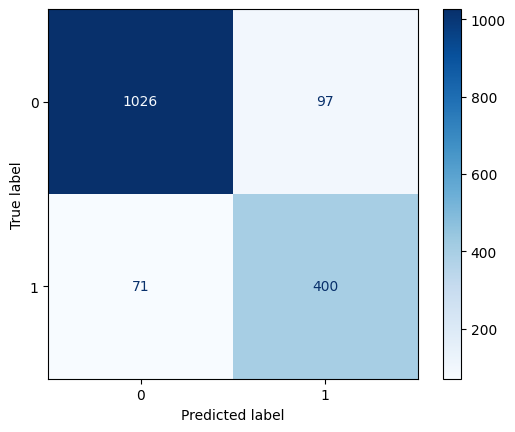

In [ ]:
#ENGLISH
model = ts.AutoModelForSequenceClassification.from_pretrained(SAVE_PATH_EN, num_labels=2, id2label=id2label, label2id=label2id)
tokenizer = ts.AutoTokenizer.from_pretrained(SAVE_PATH_EN)
tmp_trainer = ts.Trainer(
    model=model,
    args=tmp_training_args,
    tokenizer=tokenizer,
    data_collator=data_collator,
)

out = tmp_trainer.predict(tok_data_en['test'])

true = list(out[1])
pred = list(out[0].argmax(axis=-1))

print("English model")
cm = confusion_matrix(true, pred)
cm_disp = ConfusionMatrixDisplay(cm)
cm_disp.plot(cmap="Blues")

In [ ]:
en_en_acc = accuracy_score(true, pred)
en_en_bal = balanced_accuracy_score(true, pred)

print("English accuracy :" + str(en_en_acc))
print("English balanced accuracy :" + str(en_en_bal))

out = tmp_trainer.predict(tok_test_fr)

true = list(out[1])
pred = list(out[0].argmax(axis=-1))


en_fr_acc = accuracy_score(true, pred)
en_fr_bal = balanced_accuracy_score(true, pred)

print("English accuracy on French :" + str(en_fr_acc))
print("English balanced accuracy on French :" + str(en_fr_bal))

out = tmp_trainer.predict(tok_test_de)

true = list(out[1])
pred = list(out[0].argmax(axis=-1))


en_de_acc = accuracy_score(true, pred)
en_de_bal = balanced_accuracy_score(true, pred)

print("English accuracy on German :" + str(en_de_acc))
print("English balanced accuracy on German :" + str(en_de_bal))

out = tmp_trainer.predict(tok_test_ja)

true = list(out[1])
pred = list(out[0].argmax(axis=-1))


en_ja_acc = accuracy_score(true, pred)
en_ja_bal = balanced_accuracy_score(true, pred)

print("English accuracy on Japanese :" + str(en_ja_acc))
print("English balanced accuracy on Japanese :" + str(en_ja_bal))

English accuracy :0.8946047678795483
English balanced accuracy :0.8814405605246789


English accuracy on French :0.8531994981179423
English balanced accuracy on French :0.8347976019647101


English accuracy on German :0.8199498117942283
English balanced accuracy on German :0.7292275203097557


English accuracy on Japanese :0.8212045169385195
English balanced accuracy on Japanese :0.739979354663067


French model


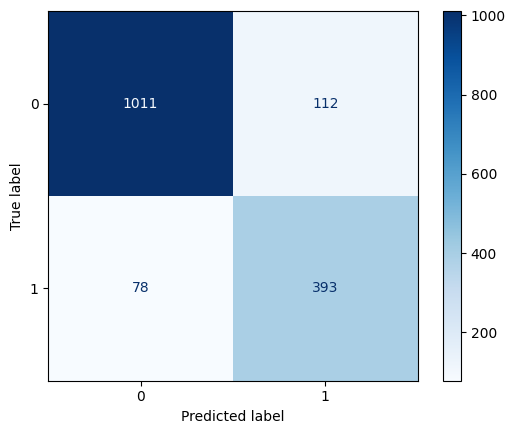

In [ ]:
#FRENCH
model = ts.AutoModelForSequenceClassification.from_pretrained(SAVE_PATH_FR, num_labels=2, id2label=id2label, label2id=label2id)
tokenizer = ts.AutoTokenizer.from_pretrained(SAVE_PATH_FR)
tmp_trainer = ts.Trainer(
    model=model,
    args=tmp_training_args,
    tokenizer=tokenizer,
    data_collator=data_collator,
)

out = tmp_trainer.predict(tok_test_fr)

true = list(out[1])
pred = list(out[0].argmax(axis=-1))

print("French model")
cm = confusion_matrix(true, pred)
cm_disp = ConfusionMatrixDisplay(cm)
cm_disp.plot(cmap="Blues")


In [ ]:
fr_fr_acc = accuracy_score(true, pred)
fr_fr_bal = balanced_accuracy_score(true, pred)

print("French accuracy :" + str(fr_fr_acc))
print("French balanced accuracy :" + str(fr_fr_bal))

out = tmp_trainer.predict(tok_data_en['test'])

true = list(out[1])
pred = list(out[0].argmax(axis=-1))


fr_en_acc = accuracy_score(true, pred)
fr_en_bal = balanced_accuracy_score(true, pred)

print("French accuracy on English :" + str(fr_en_acc))
print("French balanced accuracy on English :" + str(fr_en_bal))

out = tmp_trainer.predict(tok_test_de)

true = list(out[1])
pred = list(out[0].argmax(axis=-1))


fr_de_acc = accuracy_score(true, pred)
fr_de_bal = balanced_accuracy_score(true, pred)

print("French accuracy on German :" + str(fr_de_acc))
print("French balanced accuracy on German :" + str(fr_de_bal))

out = tmp_trainer.predict(tok_test_ja)

true = list(out[1])
pred = list(out[0].argmax(axis=-1))


fr_ja_acc = accuracy_score(true, pred)
fr_ja_bal = balanced_accuracy_score(true, pred)

print("French accuracy on Japanese :" + str(fr_ja_acc))
print("French balanced accuracy on Japanese :" + str(fr_ja_bal))

French accuracy :0.8808030112923463
French balanced accuracy :0.8673310230218194


French accuracy on English :0.848180677540778
French balanced accuracy on English :0.7924065997016635


French accuracy on German :0.814930991217064
French balanced accuracy on German :0.7188859458570367


French accuracy on Japanese :0.8193224592220828
French balanced accuracy on Japanese :0.747272338840647


German model


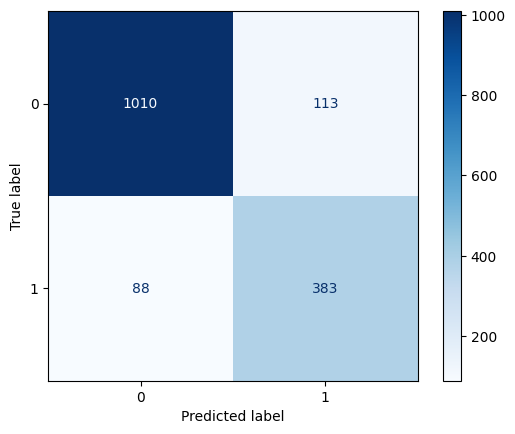

In [ ]:
#GERMAN
model = ts.AutoModelForSequenceClassification.from_pretrained(SAVE_PATH_DE, num_labels=2, id2label=id2label, label2id=label2id)
tokenizer = ts.AutoTokenizer.from_pretrained(SAVE_PATH_DE)
tmp_trainer = ts.Trainer(
    model=model,
    args=tmp_training_args,
    tokenizer=tokenizer,
    data_collator=data_collator,
)

out = tmp_trainer.predict(tok_test_de)

true = list(out[1])
pred = list(out[0].argmax(axis=-1))

print("German model")
cm = confusion_matrix(true, pred)
cm_disp = ConfusionMatrixDisplay(cm)
cm_disp.plot(cmap="Blues")

In [ ]:
de_de_acc = accuracy_score(true, pred)
de_de_bal = balanced_accuracy_score(true, pred)

print("German accuracy :" + str(de_de_acc))
print("German balanced accuracy :" + str(de_de_bal))

out = tmp_trainer.predict(tok_data_en['test'])

true = list(out[1])
pred = list(out[0].argmax(axis=-1))


de_en_acc = accuracy_score(true, pred)
de_en_bal = balanced_accuracy_score(true, pred)

print("German accuracy on English :" + str(de_en_acc))
print("German balanced accuracy on English :" + str(de_en_bal))

out = tmp_trainer.predict(tok_test_fr)

true = list(out[1])
pred = list(out[0].argmax(axis=-1))


de_fr_acc = accuracy_score(true, pred)
de_fr_bal = balanced_accuracy_score(true, pred)

print("German accuracy on French :" + str(de_fr_acc))
print("German balanced accuracy on French :" + str(de_fr_bal))

out = tmp_trainer.predict(tok_test_ja)

true = list(out[1])
pred = list(out[0].argmax(axis=-1))


de_ja_acc = accuracy_score(true, pred)
de_ja_bal = balanced_accuracy_score(true, pred)

print("German accuracy on Japanese :" + str(de_ja_acc))
print("German balanced accuracy on Japanese :" + str(de_ja_bal))

German accuracy :0.8739021329987453
German balanced accuracy :0.8562700757940986


German accuracy on English :0.8519447929736512
German balanced accuracy on English :0.8111027294572279


German accuracy on French :0.8456712672521958
German balanced accuracy on French :0.822675083611724


German accuracy on Japanese :0.8306148055207027
German balanced accuracy on Japanese :0.7959647063049573


Japanese model


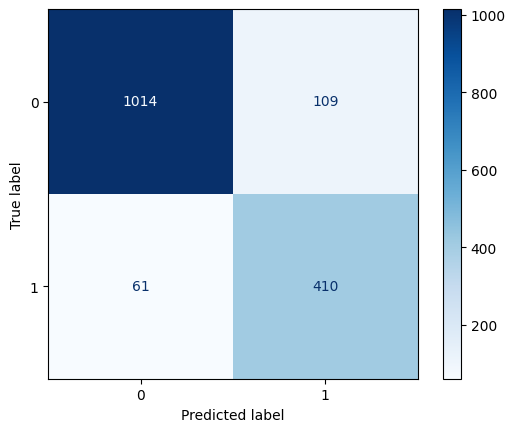

In [ ]:
#JAPANESE
model = ts.AutoModelForSequenceClassification.from_pretrained(SAVE_PATH_JA, num_labels=2, id2label=id2label, label2id=label2id)
tokenizer = ts.AutoTokenizer.from_pretrained(SAVE_PATH_JA)
tmp_trainer = ts.Trainer(
    model=model,
    args=tmp_training_args,
    tokenizer=tokenizer,
    data_collator=data_collator,
)

out = tmp_trainer.predict(tok_test_ja)

true = list(out[1])
pred = list(out[0].argmax(axis=-1))


print("Japanese model")
cm = confusion_matrix(true, pred)
cm_disp = ConfusionMatrixDisplay(cm)
cm_disp.plot(cmap="Blues")

In [ ]:
ja_ja_acc = accuracy_score(true, pred)
ja_ja_bal = balanced_accuracy_score(true, pred)

print("Japanese accuracy :" + str(ja_ja_acc))
print("Japanese balanced accuracy :" + str(ja_ja_bal))

out = tmp_trainer.predict(tok_data_en['test'])

true = list(out[1])
pred = list(out[0].argmax(axis=-1))


ja_en_acc = accuracy_score(true, pred)
ja_en_bal = balanced_accuracy_score(true, pred)

print("Japanese accuracy on English :" + str(ja_en_acc))
print("Japanese balanced accuracy on English :" + str(ja_en_bal))

out = tmp_trainer.predict(tok_test_fr)

true = list(out[1])
pred = list(out[0].argmax(axis=-1))


ja_fr_acc = accuracy_score(true, pred)
ja_fr_bal = balanced_accuracy_score(true, pred)

print("Japanese accuracy on French :" + str(ja_fr_acc))
print("Japanese balanced accuracy on French :" + str(ja_fr_bal))

out = tmp_trainer.predict(tok_test_de)

true = list(out[1])
pred = list(out[0].argmax(axis=-1))


ja_de_acc = accuracy_score(true, pred)
ja_de_bal = balanced_accuracy_score(true, pred)

print("Japanese accuracy on German :" + str(ja_de_acc))
print("Japanese balanced accuracy on German :" + str(ja_de_bal))

Japanese accuracy :0.8933500627352572
Japanese balanced accuracy :0.8867134400765315


Japanese accuracy on English :0.8368883312421581
Japanese balanced accuracy on English :0.778845335798674


Japanese accuracy on French :0.8312421580928482
Japanese balanced accuracy on French :0.7674421902206896


Japanese accuracy on German :0.8048933500627352
Japanese balanced accuracy on German :0.7031334781531877


Results of each model on each dataset.

In [ ]:
tb = pd.DataFrame({'model' : ["EN", "FR", "DE", "JA"],
                   'EN data' : [en_en_bal,fr_en_bal,de_en_bal,ja_en_bal,],
                   'FR data' : [en_fr_bal,fr_fr_bal,de_fr_bal,ja_fr_bal,],
                   'DE data' : [en_de_bal,fr_de_bal,de_de_bal,ja_de_bal],
                   'JA data' : [en_ja_bal,fr_ja_bal,de_ja_bal,ja_ja_bal,]
                   })
tb

,model,EN data,FR data,DE data,JA data
0,EN,0.881441,0.834798,0.729228,0.739979
1,FR,0.792407,0.867331,0.718886,0.747272
2,DE,0.811103,0.822675,0.856270,0.795965
3,JA,0.778845,0.767442,0.703133,0.886713
